## Normalizing Intensity Values
It is important to normalize images before comparing intensity values between channels and rounds
to decode feature traces. This tutorial will cover how to use py:class:`ClipPercentileToZero`,
:py:class:`ClipValueToZero`, and :py:class:`Clip` to normalize images within an
:py:class:`ImageStack`.
For more background on normalizing images in starfish pipelines see
:ref:`<section_normalizing_intensities>`.

When the number of spots is not known to be uniform across :py:class:`Axes` of an
:py:class:`ImageStack`, you *cannot* use :ref:`MatchHistograms<tutorial_match_histograms>` to
normalize images. Instead, you can choose minimum and maximum percentile values or pixel intensity
values to clip outlier values and rescale the distributions to be more similar.

.. note::
    See the :ref:`Normalizing Intensity Distributions<tutorial_normalizing_intensity_distributions>`
    for when you know the number of spots is uniform.

This tutorial is divided into two sections. The first section will show how to use the three
clipping :py:class:`FilterAlgorithm`\s to normalize images with varying number of spots. The second
section will show to clip and scale images so their intensity distributions match. One of these
examples may be sufficient for normalizing images in your pipeline but there are many ways to
process images and you may find a different combination of :py:class:`FilterAlgorithm`s works
best for your data. For more examples of image normalization in pipelines see the example pipelines
(eg. :ref:`Example 3D smFISH Pipeline<_smFISH_processing_example>`).

### Normalizing images with varying number of spots

This section will focus on how to set parameters of :py:class:`ClipPercentileToZero` to normalize
images from different channels but the same concepts can be applied to normalize images from
#different rounds. Other uses for :py:class:`ClipPercentileToZero` can be found in
:ref:`How To Clip Percentile To Zero<howto_clip_percentile_to_zero>`

The assumption in this example is that some of your images have fewer spots than others or no
spots at all so you can't use :py:class:`MatchHistograms` to normalize intensities. But you still
need to normalize the intensities so that your :py:class:`PerRoundMaxChannel` or
:py:class:`MetricDistance` can accurately build a feature trace and decode. To do so you need to 
know what your data looks like and what it should look like if every image had been acquired
under the exact same conditions.

The first step to normalizing is viewing the histogram of pixel intensities.

100%|██████████| 18/18 [00:00<00:00, 139.35it/s]

<starfish.ImageStack (r: 6, c: 3, z: 1, y: 988, x: 988)>


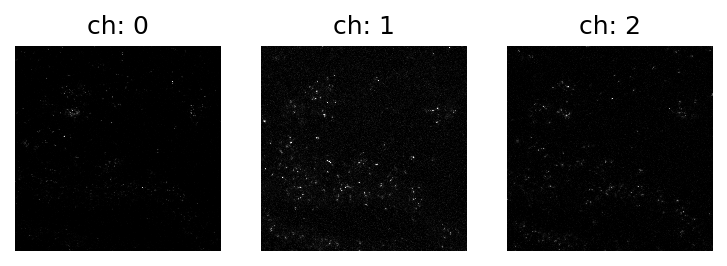

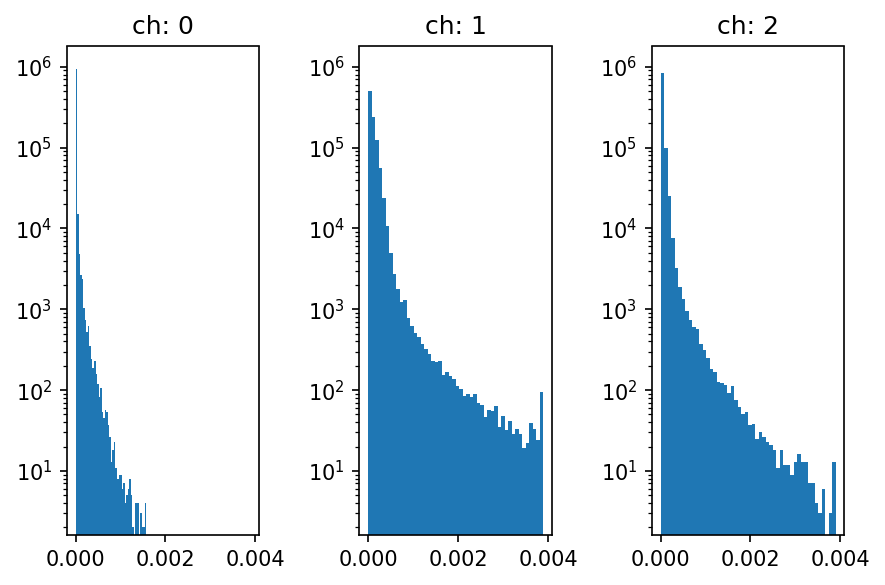

In [9]:
# Load the primary images :py:class:`ImageStack` from example DARTFISH data
import starfish.data
import matplotlib.pyplot as plt
from starfish.types import Axes
from starfish import FieldOfView
from starfish.image import Filter
from starfish.util.plot import imshow_plane, intensity_histogram

experiment = starfish.data.DARTFISH(use_test_data=False)
stack = experiment.fov().get_image(FieldOfView.PRIMARY_IMAGES)
print(stack)

# Define some useful functions for viewing multiple images and histograms
def imshow_3channels(stack: starfish.ImageStack, r: int):
    fig = plt.figure(dpi=150)
    ax1 = fig.add_subplot(131, title='ch: 0')
    ax2 = fig.add_subplot(132, title='ch: 1')
    ax3 = fig.add_subplot(133, title='ch: 2')
    imshow_plane(stack, sel={Axes.ROUND: r, Axes.CH: 0}, ax=ax1)
    imshow_plane(stack, sel={Axes.ROUND: r, Axes.CH: 1}, ax=ax2)
    imshow_plane(stack, sel={Axes.ROUND: r, Axes.CH: 2}, ax=ax3)


def plot_intensity_histograms(stack: starfish.ImageStack, r: int):
    fig = plt.figure(dpi=150)
    ax1 = fig.add_subplot(131, title='ch: 0')
    ax2 = fig.add_subplot(132, title='ch: 1', sharex=ax1, sharey=ax1)
    ax3 = fig.add_subplot(133, title='ch: 2', sharex=ax1, sharey=ax1)
    intensity_histogram(stack, sel={Axes.ROUND: r, Axes.CH: 0}, log=True, bins=50, ax=ax1)
    intensity_histogram(stack, sel={Axes.ROUND: r, Axes.CH: 1}, log=True, bins=50, ax=ax2)
    intensity_histogram(stack, sel={Axes.ROUND: r, Axes.CH: 2}, log=True, bins=50, ax=ax3)
    fig.tight_layout()

# View images and distribution of intensities in round 1
imshow_3channels(stack=stack, r=1)
plot_intensity_histograms(stack=stack, r=1)

The mean and max pixel intensity values are significantly lower in Channel 0 than the other two channels
due to having fewer spots and having less PMT gain for that channel. The objective here is to
normalize away differences like PMT gain but not alter the number of spots.

The first step is removing low-intensity background by clipping values below the minimum
percentile (p_min). The percentile to use depends on how much of the field of view is
background and what the range of pixel intensities is for background. A safe starting point is 80
for images where majority of the field of view is background.

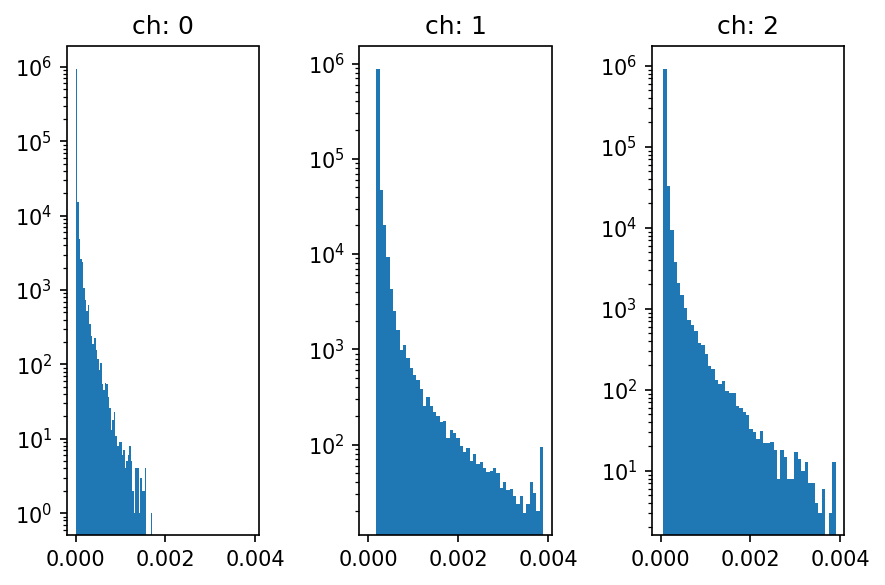

In [6]:
# Clip values below 80%
clip_below_80 = Filter.Clip(p_min=80, p_max=100)
min80_clipped = clip_below_80.run(stack, in_place=False)
plot_intensity_histograms(stack=min80_clipped, r=1)

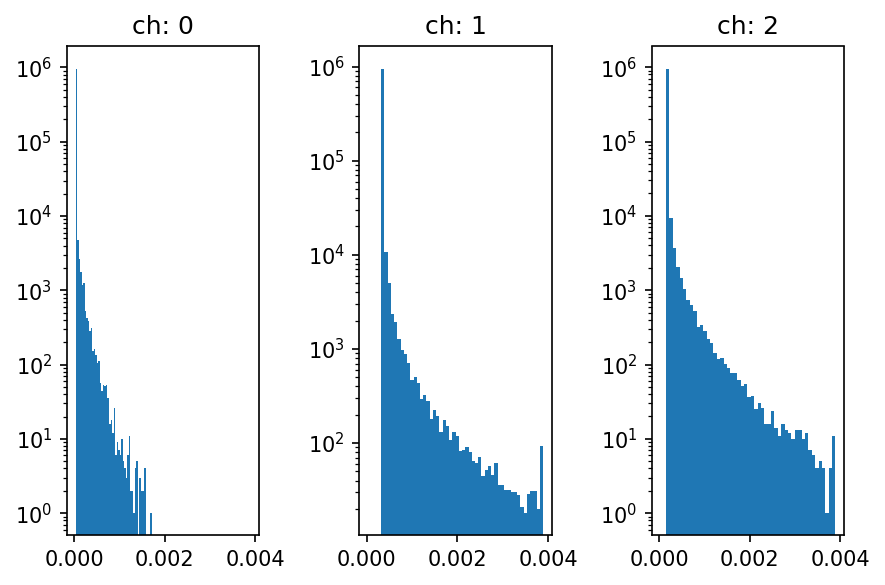

In [7]:
# Clip values below 95%
clip_below_95 = Filter.Clip(p_min=95, p_max=100)
min95_clipped = clip_below_95.run(stack, in_place=False)
plot_intensity_histograms(stack=min95_clipped, r=1)

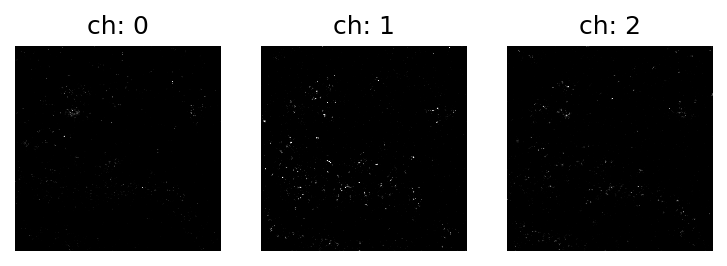

In [8]:
imshow_3channels(stack=min95_clipped, r=1)

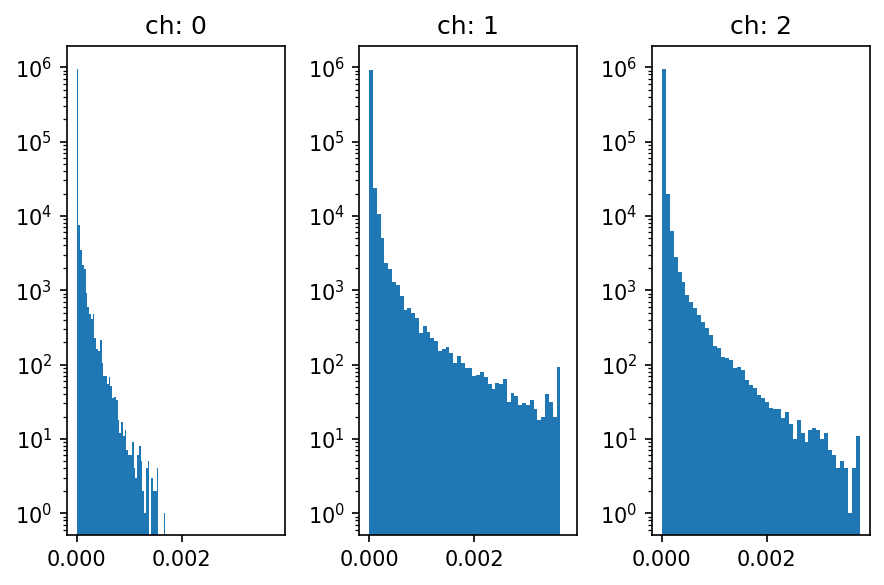

In [15]:
# Clip values below 90%
clip_below_90 = Filter.ClipPercentileToZero(p_min=90, p_max=100)
min90_clipped = clip_below_90.run(stack, in_place=False)
plot_intensity_histograms(stack=min90_clipped, r=1)

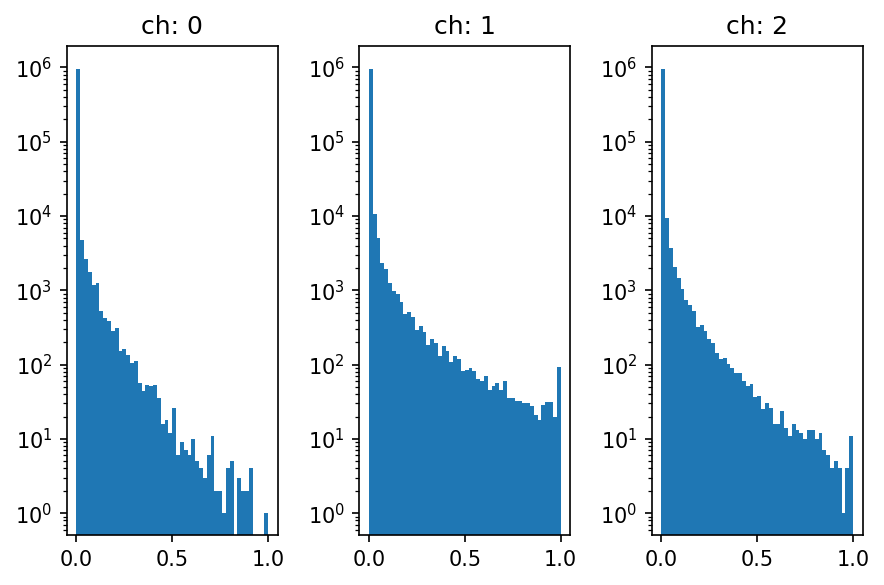

In [11]:
scale = Filter.Clip(expand_dynamic_range=True)
min95_clipped_scaled = scale.run(min95_clipped)
plot_intensity_histograms(stack=min95_clipped_scaled, r=1)

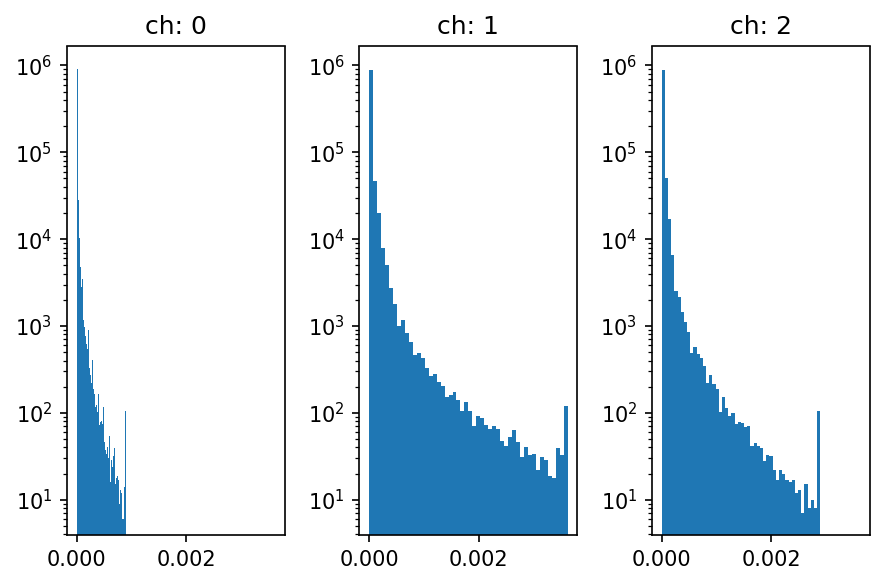

In [23]:
# Clip values below 95%
clip_below_95 = Filter.ClipPercentileToZero(p_min=80, p_max=99.99)
min95_clipped = clip_below_95.run(stack, in_place=False)
plot_intensity_histograms(stack=min95_clipped, r=1)

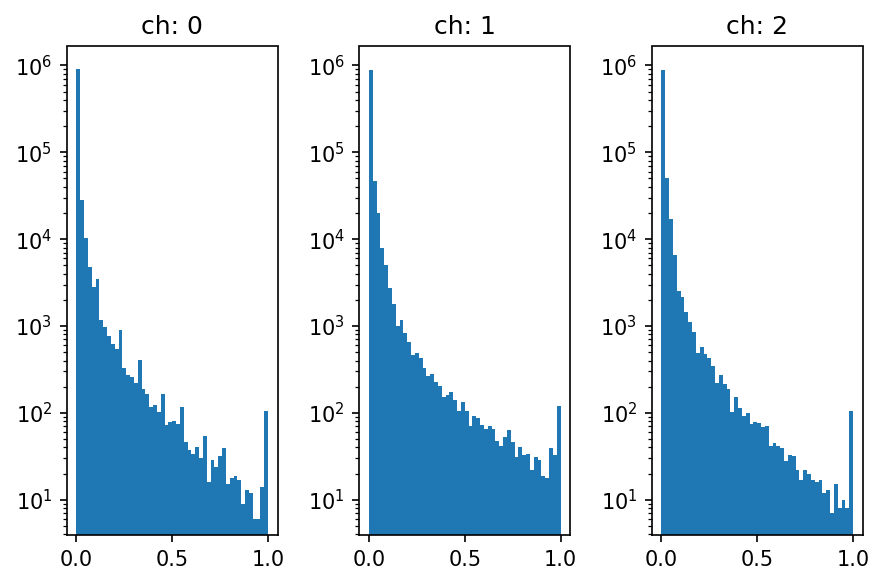

In [24]:
scale = Filter.Clip(expand_dynamic_range=True)
min95_clipped_scaled = scale.run(min95_clipped)
plot_intensity_histograms(stack=min95_clipped_scaled, r=1)

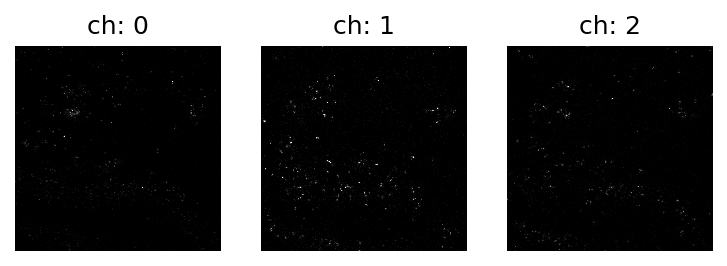

In [22]:
imshow_3channels(stack=min95_clipped_scaled, r=1)

In [26]:
bs_exp = starfish.data.BaristaSeq(use_test_data=True)

In [27]:
bs_img = bs_exp.fov().get_image(FieldOfView.PRIMARY_IMAGES)

In [37]:
clip2 = starfish.image.Filter.Clip(p_min=99, p_max=100, is_volume=True, expand_dynamic_range=True)

100%|██████████| 204/204 [00:01<00:00, 179.44it/s]


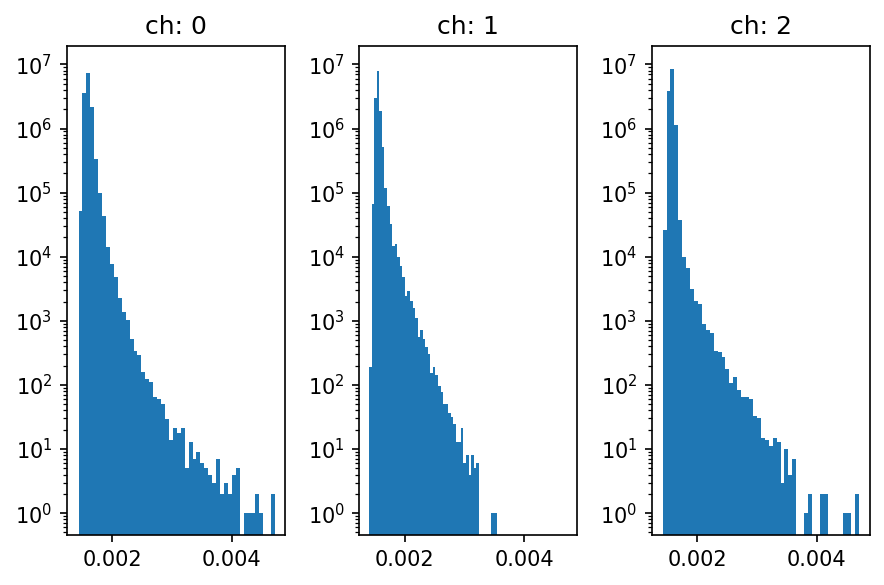

In [29]:
plot_intensity_histograms(stack=bs_img, r=1)

In [38]:
bs_img_clip2 = clip2.run(bs_img, in_place=False)

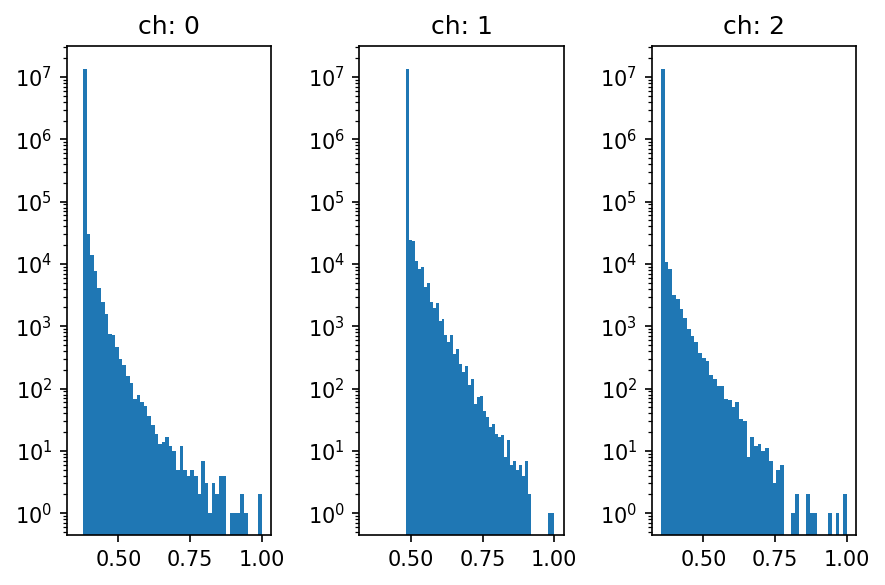

In [39]:
plot_intensity_histograms(stack=bs_img_clip2, r=1)

In [41]:
stack.sel({Axes.CH: 0})

<starfish.ImageStack (r: 6, c: 1, z: 1, y: 988, x: 988)>

In [42]:
clip_ch0 = Filter.ClipValueToZero(v_min= 0.00003, v_max= 0.0015)

In [43]:
test = stack

In [44]:
test

<starfish.ImageStack (r: 6, c: 3, z: 1, y: 988, x: 988)>

In [48]:
clip_ch0.run(stack.sel({Axes.CH: 0}))

<starfish.ImageStack (r: 6, c: 1, z: 1, y: 988, x: 988)>

In [49]:
test

<starfish.ImageStack (r: 6, c: 3, z: 1, y: 988, x: 988)>

In [51]:
test2 = test.sel({Axes.CH: 0})

In [52]:
clip_ch0.run(test2)

<starfish.ImageStack (r: 6, c: 1, z: 1, y: 988, x: 988)>